In [64]:
# Import libraries
import numpy as np
import pandas as pd
import thinkstats2
import scipy.stats as stats

# Load the NSFG data from the .py file 
import sys
sys.path.append('C:\\Users\\gjose')
import nsfg  

# Define a custom class for performing permutation-based hypothesis testing on the difference in means
class DiffMeansResample:
    """Tests a difference in means using resampling."""

    def __init__(self, data):
        self.data = data
        self.group1, self.group2 = data
        self.diff = np.mean(self.group1) - np.mean(self.group2)

    def RunModel(self):
        """Run the resampling model to generate random permutations."""
        combined = np.concatenate([self.group1, self.group2])
        np.random.shuffle(combined)
        group1_perm = combined[:len(self.group1)]
        group2_perm = combined[len(self.group1):]
        return group1_perm, group2_perm

    def PValue(self, iters=10000):
        """Calculate the p-value by resampling."""
        observed_diff = np.abs(self.diff)
        count = 0
        for _ in range(iters):
            group1_perm, group2_perm = self.RunModel()
            perm_diff = np.abs(np.mean(group1_perm) - np.mean(group2_perm))
            if perm_diff >= observed_diff:
                count += 1
        p_value = count / iters
        return p_value

    def MaxTestStat(self):
        """Calculate the maximum test statistic."""
        max_stat = 0
        for _ in range(10000):
            group1_perm, group2_perm = self.RunModel()
            diff = np.abs(np.mean(group1_perm) - np.mean(group2_perm))
            max_stat = max(max_stat, diff)
        return max_stat


# Function to run tests with different sample sizes
def run_tests_with_different_sample_sizes(data, sample_sizes):
    for size in sample_sizes:
        # Randomly sample from the dataset
        sample = thinkstats2.SampleRows(data, size)
        
        # Separate the groups (first babies vs. others)
        first_babies = sample[sample['birthord'] == 1]['prglngth']
        others = sample[sample['birthord'] != 1]['prglngth']
        
        # Perform resampling-based test for difference in means
        ht = DiffMeansResample((first_babies, others))
        
        # Calculate p-value using 10,000 iterations for better accuracy
        p_value = ht.PValue(iters=10000)
        
        # Print result for this sample size
        print(f"Sample size: {size} | p-value: {p_value:.8f}")  # Show full p-value with 8 decimals

        if p_value < 0.05:
            print("Result: Statistically significant")
        else:
            print("Result: Not significant")


# Function to track the smallest sample size with a positive test
def smallest_sample_size_for_positive_test(data, max_sample_size=5000):
    sample_sizes = list(range(100, max_sample_size + 1, 100))
    for size in sample_sizes:
        # Randomly sample from the dataset
        sample = thinkstats2.SampleRows(data, size)
        
        # Separate the groups (first babies vs. others)
        first_babies = sample[sample['birthord'] == 1]['prglngth']
        others = sample[sample['birthord'] != 1]['prglngth']
        
        # Perform resampling-based test for difference in means
        ht = DiffMeansResample((first_babies, others))
        p_value = ht.PValue(iters=10000)
        
        if p_value < 0.05:
            return size, p_value  # Return the sample size that passed the test

    return None, None  # No sample size passed the test


# Load the NSFG dataset using nsfg.py
nsfg_data = nsfg.ReadFemPreg()  

# Define a list of sample sizes to test
sample_sizes = [100, 500, 1000, 5000]

# Run the tests with different sample sizes
run_tests_with_different_sample_sizes(nsfg_data, sample_sizes)

# Track the smallest sample size that gives a positive test
smallest_size, p_value = smallest_sample_size_for_positive_test(nsfg_data)
if smallest_size:
    print(f"The smallest sample size that yields a positive test is: {smallest_size} with p-value: {p_value:.8f}")
else:
    print("No sample size yielded a positive test.")


Sample size: 100 | p-value: 0.00000000
Result: Statistically significant
Sample size: 500 | p-value: 0.00000000
Result: Statistically significant
Sample size: 1000 | p-value: 0.00000000
Result: Statistically significant
Sample size: 5000 | p-value: 0.00000000
Result: Statistically significant
The smallest sample size that yields a positive test is: 100 with p-value: 0.00000000


In [ ]:
# What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yields a postive test?
# As the sample size decreases, the statistical power of the hypothesis test generally decreases as well.
# The smallest sample size that gives a statistically significant result (p-value less than 0.05) is 100.

Height (cm):
key	n	mean	var	std	cv
all	414509	168.83	107.18	10.35	0.0613
male	155703	178.07	59.65	7.72	0.0434
female	258806	163.22	52.84	7.27	0.0445
Weight (kg):
key	n	mean	var	std	cv
all	414509	0.79	0.04	0.20	0.2474
male	155703	0.89	0.03	0.18	0.2049
female	258806	0.73	0.03	0.18	0.2423
Weight year ago (kg):
key	n	mean	var	std	cv
all	414509	36.24	87.38	9.35	0.2580
male	155703	40.85	76.65	8.75	0.2143
female	258806	33.31	72.09	8.49	0.2549
Linear regression results:
Slope: 0.0122, Intercept: -2.3185, p-value: 0.0000


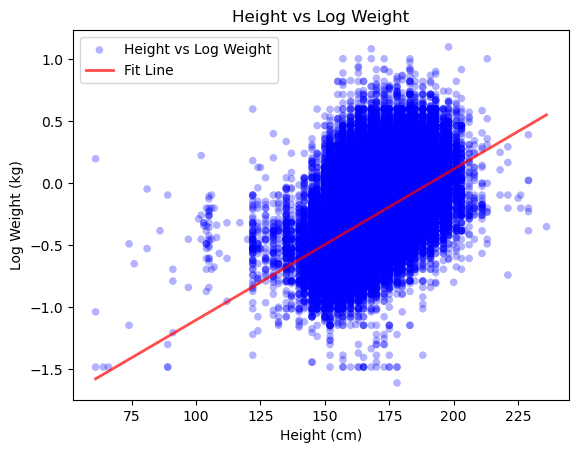

<Figure size 800x600 with 0 Axes>

In [66]:
import warnings
import pandas as pd

# Suppress specific pandas FutureWarnings related to chained assignment
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
from scipy import stats
import brfss

def Summarize(df, column, title):
    """Print summary statistics male, female, and all."""
    items = [
        ('all', df[column]),
        ('male', df[df.sex == 1][column]),
        ('female', df[df.sex == 2][column]),
    ]
    
    print(title)
    print('key\tn\tmean\tvar\tstd\tcv')
    for key, series in items:
        mean, var = series.mean(), series.var()
        std = np.sqrt(var)
        cv = std / mean
        t = key, len(series), mean, var, std, cv
        print('%s\t%d\t%4.2f\t%4.2f\t%4.2f\t%4.4f' % t)

def CleanBrfssFrame(df):
    """Recodes BRFSS variables."""
    # Clean age (replace 7 and 9 with NaN)
    df['age'] = df['age'].replace([7, 9], float('NaN'))

    # Clean height (replace 999 with NaN)
    df['htm3'] = df['htm3'].replace([999], float('NaN'))

    # Clean weight (replace 99999 with NaN, then scale by 100)
    df['wtkg2'] = df['wtkg2'].replace([99999], float('NaN'))
    df['wtkg2'] = df['wtkg2'] / 100.0

    # Clean weight a year ago (replace 7777 and 9999 with NaN)
    df['wtyrago'] = df['wtyrago'].replace([7777, 9999], float('NaN'))
    df['wtyrago'] = df['wtyrago'].apply(lambda x: x / 2.2 if x < 9000 else x - 9000)

def PerformLinearRegressionAndPlot(df):
    """Performs linear regression between height and log-transformed weight."""
    # Log transform weight
    df['log_weight'] = np.log(df['wtkg2'])  # Log transform the weight variable

    # Step 1: Drop rows where either height or log_weight is NaN
    df_clean = df[['htm3', 'log_weight']].dropna()

    # Step 2: Perform linear regression using the cleaned data
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['htm3'], df_clean['log_weight'])
    print(f"Linear regression results:\nSlope: {slope:.4f}, Intercept: {intercept:.4f}, p-value: {p_value:.4f}")

    # Step 3: Plot the data and regression line
    thinkplot.Scatter(df_clean['htm3'], df_clean['log_weight'], label='Height vs Log Weight', color='blue', alpha=0.3)
    thinkplot.Plot([df_clean['htm3'].min(), df_clean['htm3'].max()],
                   [slope * df_clean['htm3'].min() + intercept, slope * df_clean['htm3'].max() + intercept],
                   label='Fit Line', color='red', linewidth=2)
    thinkplot.Config(title="Height vs Log Weight", xlabel="Height (cm)", ylabel="Log Weight (kg)")
    thinkplot.Show()

def MakeFigures(df):
    """Generates CDFs and normal probability plots for weights and log weights."""
    weights = df['wtkg2'].dropna()
    log_weights = np.log10(weights)

    # Plot weights on linear and log scales
    thinkplot.PrePlot(cols=2)
    MakeNormalModel(weights)
    thinkplot.Config(xlabel='adult weight (kg)', ylabel='CDF')

    thinkplot.SubPlot(2)
    MakeNormalModel(log_weights)
    thinkplot.Config(xlabel='adult weight (log10 kg)')

    thinkplot.Save(root='brfss_weight')

    # Make normal probability plots on linear and log scales
    thinkplot.PrePlot(cols=2)
    MakeNormalPlot(weights)
    thinkplot.Config(xlabel='z', ylabel='weights (kg)')

    thinkplot.SubPlot(2)
    MakeNormalPlot(log_weights)
    thinkplot.Config(xlabel='z', ylabel='weights (log10 kg)')

    thinkplot.Save(root='brfss_weight_normal')

def main():
    """Main function to perform the analysis."""
    # Load the BRFSS data (path should be correct)
    brfss_data = brfss.ReadBrfss('C:\\Users\\gjose\\CDBRFS08.ASC.gz')

    # Clean the data
    CleanBrfssFrame(brfss_data)

    # Step 1: Summarize the data
    Summarize(brfss_data, 'htm3', 'Height (cm):')
    Summarize(brfss_data, 'wtkg2', 'Weight (kg):')
    Summarize(brfss_data, 'wtyrago', 'Weight year ago (kg):')

    # Step 2: Perform linear regression and plot
    PerformLinearRegressionAndPlot(brfss_data)

if __name__ == '__main__':
    main()